In [1]:
import nltk
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import bokeh
import matplotlib.pyplot as plt
import pylab as pl
from ast import literal_eval
import string
import random
from scipy.cluster.hierarchy import linkage, dendrogram, to_tree
from sklearn.metrics.pairwise import cosine_similarity
import re
from nltk.stem import WordNetLemmatizer

In [2]:
DATA_MAG = "../data/raw/winemag-data-130k-v2.csv"

In [3]:
df = pd.read_csv(DATA_MAG, index_col=0)
df.shape

(129971, 13)

In [4]:
df = df.drop_duplicates()
df.shape

(119988, 13)

In [5]:
# Just a minor terminology correction
df.rename(columns={'variety': 'varietal'}, inplace=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1ca21208>]],
      dtype=object)

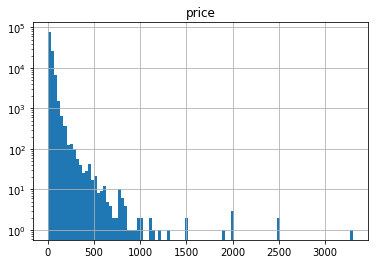

In [6]:
df.hist(column = 'price', bins=100, log=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1932c5f8>]],
      dtype=object)

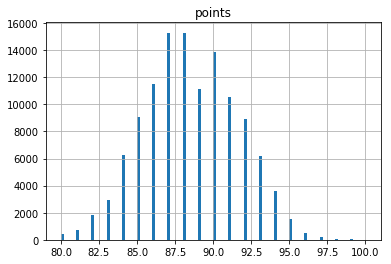

In [7]:
# Nice bell-curve looking kinda distribution
df.hist(column = 'points', bins=100)

In [8]:
df['unique_taster'] = df['taster_name'] + df['taster_twitter_handle'].fillna('__notwitter')

In [9]:
df['unique_taster'].value_counts()

Roger Voss@vossroger                23560
Michael Schachner@wineschach        14046
Kerin O’Keefe@kerinokeefe            9697
Paul Gregutt@paulgwine               8868
Virginie Boone@vboone                8708
Matt Kettmann@mattkettmann           5730
Joe Czerwinski@JoeCz                 4766
Sean P. Sullivan@wawinereport        4461
Anna Lee C. Iijima__notwitter        4017
Jim Gordon@gordone_cellars           3766
Anne Krebiehl MW@AnneInVino          3290
Lauren Buzzeo@laurbuzz               1700
Susan Kostrzewa@suskostrzewa         1023
Mike DeSimone@worldwineguys           461
Jeff Jenssen@worldwineguys            436
Alexander Peartree__notwitter         383
Carrie Dykes__notwitter               129
Fiona Adams@bkfiona                    24
Christina Pickard@winewchristina        6
Name: unique_taster, dtype: int64

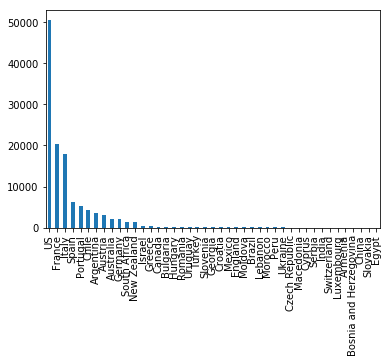

In [10]:
# a few countries produce most of the wines here
fig, ax = plt.subplots()
df['country'].value_counts().plot(ax=ax, kind='bar')

In [11]:
df['province'].value_counts()[:10]

California          33656
Washington           7965
Bordeaux             5556
Tuscany              5391
Oregon               4929
Burgundy             3683
Northern Spain       3554
Piedmont             3441
Mendoza Province     3038
Veneto               2501
Name: province, dtype: int64

In [12]:
df['varietal'].value_counts()[:50]

Pinot Noir                       12278
Chardonnay                       10868
Cabernet Sauvignon                8840
Red Blend                         8243
Bordeaux-style Red Blend          6471
Riesling                          4773
Sauvignon Blanc                   4575
Syrah                             3828
Rosé                              3220
Merlot                            2896
Nebbiolo                          2607
Zinfandel                         2530
Sangiovese                        2462
Malbec                            2446
Portuguese Red                    2282
White Blend                       2179
Sparkling Blend                   1971
Tempranillo                       1671
Rhône-style Red Blend             1343
Pinot Gris                        1324
Champagne Blend                   1308
Cabernet Franc                    1243
Grüner Veltliner                  1201
Portuguese White                  1057
Bordeaux-style White Blend         993
Pinot Grigio             

Uh-oh. Looks like there are 2 big confusions: 'Syrah' & 'Shiraz' are the same grape. Something called 'Sauvignon', which should really be 'Sauvignon Blanc'. Let's just check to be sure that it's not 'Sauvignon Vert' or sth.

In [13]:
df[df['varietal']=='Sauvignon']['province'].value_counts()

Northeastern Italy      252
Northern Spain            5
Veneto                    3
Central Italy             3
Sicily & Sardinia         3
Piedmont                  2
Südsteiermark             2
Southern Italy            1
Bordeaux                  1
Languedoc-Roussillon      1
Loire Valley              1
Štajerska                 1
Tikves                    1
Vipavska Dolina           1
Victoria                  1
Dealu Mare                1
Brda                      1
Marlborough               1
Tuscany                   1
Name: province, dtype: int64

In [14]:
df[df['varietal']=='Sauvignon']['taster_name'].value_counts()

Kerin O’Keefe         165
Michael Schachner       5
Roger Voss              2
Anna Lee C. Iijima      2
Anne Krebiehl MW        2
Jeff Jenssen            2
Joe Czerwinski          2
Susan Kostrzewa         1
Name: taster_name, dtype: int64

In [15]:
df[(df['varietal']=='Sauvignon') & (df['taster_name']=="Kerin O’Keefe")][['title','description']]

,title,description
650,Sturm 2014 Sauvignon (Collio),"You'll find aromas of tomato leaf, passion fru..."
1292,Cembra 2013 Sauvignon (Trentino),This vibrant wine opens with varietal aromas o...
1399,Caldaro 2014 Sauvignon (Alto Adige),"Varietal scents of cut grass, grapefruit and a..."
1403,Manincor 2014 Tannenberg Sauvignon (Alto Adige...,This lively white opens with aromas of grapefr...
1408,Nals Margreid 2014 Sauvignon (Alto Adige),This linear wine opens with aromas that sugges...
2725,MandraRossa 2015 Urra di Mare Sauvignon (Sicilia),"Aromas suggesting honeydew melon, exotic fruit..."
3905,Ronco dei Tassi 2014 Sauvignon (Collio),"Grapefruit, mineral and freshly cut grass arom..."
3911,La Vis 2014 Vigna Maso Tratta Sauvignon (Trent...,"Delicate varietal aromas of tomato vine, cut g..."
6259,St. Pauls 2013 Passion Sauvignon (Alto Adige),Made with Sauvignon cultivated in high mountai...
6885,Ca'Ronesca 2014 Sauvignon (Collio),"Aromas of pineapple, peach and a touch of vani..."


Googling some of these bottles showed that they are indeed Sauvignon Blanc.

In [16]:
df['varietal'] = df['varietal'].map(lambda x: 'Sauvignon Blanc' if x == 'Sauvignon' else x)
df['varietal'] = df['varietal'].map(lambda x: 'Shiraz' if x == 'Syrah' else x)

The average (mean) province contributes about 300 wines to the list. But obviously some provinces dominate.

In [17]:
df.province.value_counts().nlargest(25)

California            33656
Washington             7965
Bordeaux               5556
Tuscany                5391
Oregon                 4929
Burgundy               3683
Northern Spain         3554
Piedmont               3441
Mendoza Province       3038
Veneto                 2501
New York               2456
Alsace                 2219
Northeastern Italy     1967
Loire Valley           1691
Sicily & Sardinia      1634
Champagne              1498
Southwest France       1385
South Australia        1271
Southern Italy         1254
Provence               1197
Douro                  1179
Central Italy          1134
Catalonia              1053
Rhône Valley            985
Mosel                   945
Name: province, dtype: int64

In [18]:
df.groupby(['province', 'varietal'])['description'].count().nlargest(50)

province            varietal                     
California          Pinot Noir                       6418
                    Cabernet Sauvignon               5328
                    Chardonnay                       4784
Bordeaux            Bordeaux-style Red Blend         4336
Oregon              Pinot Noir                       2560
Piedmont            Nebbiolo                         2478
California          Zinfandel                        2458
Burgundy            Chardonnay                       2130
Tuscany             Red Blend                        1988
                    Sangiovese                       1949
California          Shiraz                           1784
                    Sauvignon Blanc                  1675
                    Red Blend                        1667
Burgundy            Pinot Noir                       1443
California          Merlot                           1296
Mendoza Province    Malbec                           1265
Washington          Ca

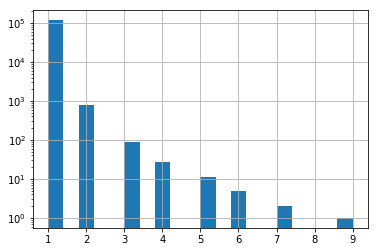

In [19]:
df['title'].value_counts().hist(bins=20, log=True)

Most wines appear only once, but seems like a few appears multiple times

In [20]:
df.groupby(by='country')['designation'].value_counts().nlargest(20)

country    designation    
US         Reserve            1388
           Estate             1119
Italy      Riserva             639
US         Estate Grown        549
Chile      Reserva             492
France     Barrel sample       367
Spain      Crianza             312
US         Dry                 300
France     Vieilles Vignes     279
           Barrel Sample       251
Spain      Reserva             249
US         Estate Bottled      233
Portugal   Reserva             212
Argentina  Reserva             207
France     Tradition           197
Italy      Brut                171
US         Old Vine            171
Italy      Extra Dry           166
US         Rosé of             158
France     Brut Rosé           150
Name: designation, dtype: int64

The designation doesn't seem to be anything regulated like AOC or AOP or DOCG

In [21]:
df['country_varietal'] = df['country']+ ' ' +df['varietal']
df['province_varietal'] = df['province'] + ' ' + df['varietal']

In [22]:
top_grape = df['varietal'].value_counts().nlargest(50).to_frame('count').reset_index()
top_grape.rename(columns={'index':'varietal'}, inplace=True)
top_grape

,varietal,count
0,Pinot Noir,12278
1,Chardonnay,10868
2,Cabernet Sauvignon,8840
3,Red Blend,8243
4,Bordeaux-style Red Blend,6471
5,Sauvignon Blanc,4857
6,Riesling,4773
7,Shiraz,4618
8,Rosé,3220
9,Merlot,2896


In [23]:
top_grape_country = df['country_varietal'].value_counts().nlargest(75).to_frame('count').reset_index()
top_grape_country.rename(columns={'index':'country_varietal'}, inplace=True)

In [39]:
country_df = df.groupby(by='country').agg({'points':'median','price':'median','description':'; '.join}).reset_index()
varietal_df = df.groupby(by='varietal').agg({'points':'median','price':'median','description':'; '.join}).reset_index()
country_varietal_df = df.groupby(by=['country','varietal']).agg({'points':'median','price':'median','description':'; '.join}).reset_index()
country_varietal_df['country_varietal'] = country_varietal_df['country'] + ' ' + country_varietal_df['varietal']
country_varietal_df.head()

,country,varietal,points,price,description,country_varietal
0,Argentina,Barbera,85.0,18.0,"This smells roasted, leathery and earthy, with...",Argentina Barbera
1,Argentina,Bonarda,87.0,15.0,"Meaty and rubbery, but that's young Bonarda. T...",Argentina Bonarda
2,Argentina,Bordeaux-style Red Blend,91.0,37.0,"Flat in color, with a dull luster, this smells...",Argentina Bordeaux-style Red Blend
3,Argentina,Bordeaux-style White Blend,83.0,14.0,"Bland and chunky, with aromas of talcum powder...",Argentina Bordeaux-style White Blend
4,Argentina,Cabernet Blend,88.0,30.0,This blend of 88% Cabernet Sauvignon and 12% C...,Argentina Cabernet Blend


In [40]:
province_varietal_df = df.groupby(by=['province','varietal']).agg({'points':'median','price':'median','description':'; '.join}).reset_index()
province_varietal_df['province_varietal'] = province_varietal_df['province'] + ' ' + province_varietal_df['varietal']

In [26]:
# obtain grape name tokens for later removal from description
grape_names = df['varietal'].fillna('').unique().tolist()
grape_tokens = []
for name in grape_names:
    name = name.lower()
    tokens = re.split('[- ]', name)
    grape_tokens += tokens

In [27]:
wine_remove_words = ['wine','rosé', 'red', 'white', 'drink', 'aroma', 'flavor','vineyard', 
                     'zin','acidity', 'structure', 'note']
other_remove_words = ['\'s', "'"]

In [28]:
post_lem_remove = set(wine_remove_words + other_remove_words)
pre_lem_remove = set([p for p in string.punctuation] + nltk.corpus.stopwords.words('english') + grape_tokens)
#use set to improve performance

def clean_tokenizer(text):
    """Turn long text into lowercase tokens, remove punctuations & stopwords
    e.g: fro"""
    tokens = nltk.tokenize.word_tokenize(text.lower())
    lemmatizer = WordNetLemmatizer()
    
    clean_tokens = [lemmatizer.lemmatize(t) for t in tokens if not 
                    ((t in pre_lem_remove) or (lemmatizer.lemmatize(t) in post_lem_remove) or (t.isnumeric()))]
    
    return clean_tokens

tfidf = TfidfVectorizer(lowercase=False, tokenizer=clean_tokenizer, token_pattern=None,
                        stop_words=None, max_df=0.7, min_df=10, ngram_range=(1,3))
# discarding terms that occur > 70% of the time & < 10 times. Using both normal & bigrams
tfidf_cv = TfidfVectorizer(lowercase=False, tokenizer=clean_tokenizer, token_pattern=None,
                        stop_words=None, max_df=0.7, min_df=10, ngram_range=(1,3))
tfidf_pv = TfidfVectorizer(lowercase=False, tokenizer=clean_tokenizer, token_pattern=None,
                        stop_words=None, max_df=0.7, min_df=10, ngram_range=(1,3))

In [29]:
tfidf_matrix = tfidf.fit_transform(varietal_df['description'])
tfidf_matrix_cv = tfidf_cv.fit_transform(country_varietal_df['description'])
tfidf_matrix_pv = tfidf_pv.fit_transform(province_varietal_df['description'])

In [30]:
tfidf_matrix.shape, tfidf_matrix_cv.shape, tfidf_matrix_pv.shape

((705, 28479), (1592, 32865), (4074, 36561))

In [31]:
def top_tfidf_feats(tfidf_row, features, n_feats=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    top_ids = np.argsort(tfidf_row)[::-1][:n_feats]
    # sort features in row (by tfidf score) -> ascending
    # then reverse to get descending, then slice top n
    
    top_features = [(features[i], tfidf_row[i]) for i in top_ids]
    df = pd.DataFrame(top_features) # return as a Dataframe
    df.columns = ['feature', 'tfidf']
    return df

def top_feats_in_doc(tfidf_matrix, features, row_id, n_feats=25):
    ''' Top tfidf features in specific document (matrix row)
    Gotta call this instead of top_tf_idf_feats because tfidf
    is sparse matrix -> does not support all matrix operations.
    '''
    # first convert a row to full matrix format
    row = np.squeeze(tfidf_matrix[row_id].toarray())
    
    # return a df
    return top_tfidf_feats(row, features, n_feats)

In [52]:
features = tfidf.get_feature_names()
features_cv = tfidf_cv.get_feature_names()
features_pv = tfidf_pv.get_feature_names()

def look_at(var, name, n_feats=10):
    if var=='v':
        tfidf_object = tfidf_matrix; feature_names = features; col = 'varietal'; grapes_df=varietal_df
    elif var == 'cv':
        tfidf_object = tfidf_matrix_cv; feature_names = features_cv; col = 'country_varietal'; grapes_df=country_varietal_df
    elif var == 'pv':
        tfidf_object = tfidf_matrix_pv; feature_names = features_pv; col = 'province_varietal'; grapes_df=province_varietal_df

    row = grapes_df[grapes_df[col]==name]
    row_id = row.index
    return top_feats_in_doc(tfidf_object, feature_names, row_id, n_feats=n_feats)

def look_at_random(n=10, n_feats=10):
    '''Look at n random wines'''
    row_ids = random.sample(range(1, 100), n)
    for row_id in row_ids:
        print('_'*10)
        print(varietal_df.iloc[row_id]['varietal'])
        print(top_feats_in_doc(tfidf_matrix, features,row_id, n_feats=n_feats))

def look_at_random_cv(n=10, n_feats=10):
    '''Look at n random wines'''
    row_ids = random.sample(range(1, 100), n)
    for row_id in row_ids:
        print('_'*10)
        print(country_varietal_df.iloc[row_id]['country_varietal'])
        print(top_feats_in_doc(tfidf_matrix_2, features_2,row_id, n_feats=n_feats))

In [33]:
# the next 2 lines are a repeat of a previous cell
top_grape = df['varietal'].value_counts().nlargest(57).to_frame('count').reset_index()
top_grape.rename(columns={'index':'varietal'}, inplace=True)

top_grape_names = top_grape['varietal'].tolist()
top_grape_names = [grape for grape in top_grape_names if grape not in 
                   ["Red Blend","White Blend","Sparkling Blend", "Port", "Rosé"]]
print(len(top_grape_names))
for grape in top_grape_names[:10]:
    print('_________________')
    print(grape)
    look_at('v', grape, n_feats=5)

52
_________________
Pinot Noir
     feature     tfidf
0     cherry  0.424842
1  raspberry  0.221202
2     tannin  0.210354
3       cola  0.168092
4        oak  0.142026
_________________
Chardonnay
     feature     tfidf
0        oak  0.221861
1       pear  0.221038
2  pineapple  0.192234
3      lemon  0.180481
4       ripe  0.172705
_________________
Cabernet Sauvignon
      feature     tfidf
0      tannin  0.305982
1  blackberry  0.289671
2      cherry  0.268542
3         oak  0.210463
4     currant  0.195179
_________________
Bordeaux-style Red Blend
  feature     tfidf
0  tannin  0.435789
1    ripe  0.196651
2    wood  0.173058
3    firm  0.170804
4    rich  0.147465
_________________
Sauvignon Blanc
      feature     tfidf
0      citrus  0.250898
1       green  0.248316
2  grapefruit  0.234558
3        lime  0.226953
4       crisp  0.186931
_________________
Riesling
  feature     tfidf
0     dry  0.248189
1   lemon  0.234040
2   peach  0.219856
3    lime  0.190359
4  citrus  0.1

In [53]:
top_pv = list(df['province_varietal'].value_counts().nlargest(100).index)

In [67]:
collector = {}
for pv in top_pv:
    collector[pv] = look_at('pv', pv, 20).to_dict(orient='records')

In [71]:
import json

with open('../data/intermediary/tfidf.json', 'w') as fp:
    json.dump(collector, fp)

In [78]:
import scipy.sparse
scipy.sparse.save_npz('../data/intermediary/tfidf_matrix.npy', tfidf_matrix_pv)

In [80]:
with open('../data/intermediary/features.txt', 'w') as f:
    for item in features_pv:
        f.write(f"{item}\n")

In [81]:
province_varietal_df.to_csv('../data/intermediary/province_varietal.csv', index=False)